На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:

* В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
* Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия. Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

## Задания:
1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.

## Описание данных
`5_task_1:`

* id – id клиента в эксперименте
* group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
* events – сколько блюд суммарно было заказано за период

`5_task_2:`

* id – id клиента в эксперименте
* segment – сегмент (high/low)
* group – вид кнопки (control – старая версия, test – новая версия)
* events – сколько блюд суммарно было заказано за период

# Задание 1

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

A – прямоугольные 16:9

B – квадратные

C – прямоугольные 12:4

Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?


**покупки зав от формата фото - 3 группы**
<br>**1 фактор - формат фото**

* t-test
* сделаю вывод исключительно по графику
* **ANOVA**
* посчитаю хи-квадрат

# Задание 2

Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

Hint: scipy.stats.levene либо pingouin.homoscedasticity

## ОТСУТСТВУЕТ .CSV ФАЙЛ - ИСПОЛЬЗУЮ ДАННЫЕ ДЛЯ ANOVA ИЗ КУРСА КАРПОВА НА СТЕПИКЕ
и меняю условия заданий под эти данные

https://stepik.org/lesson/8083/step/1?unit=1362

https://stepik.org/media/attachments/lesson/8083/genetherapy.csv

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pingouin 

import warnings
warnings.filterwarnings("ignore")

In [70]:
df = pd.read_csv('genetherapy.csv')
df.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [71]:
df = df.rename(columns={'INSTRUMENT': 'Therapy', 'Concerts': 'expr' })
df.head()

,expr,Therapy
0,100,A
1,96,A
2,101,A
3,95,A
4,103,A


In [72]:
df=df.reset_index()
df.head()

,index,expr,Therapy
0,0,100,A
1,1,96,A
2,2,101,A
3,3,95,A
4,4,103,A


In [73]:
df2 = pd.read_csv('data2/atherosclerosis.csv')
df2=df2.reset_index()
df2.head()

,index,expr,age,dose
0,0,107.351478,1,D1
1,1,104.504438,1,D1
2,2,103.435134,1,D1
3,3,109.572882,1,D1
4,4,114.993803,1,D1


In [74]:
pingouin.homoscedasticity(data=df, dv='expr', group='Therapy')
#дисперсии равны    H0 не отвергнута

,W,pval,equal_var
levene,0.647791,0.587633,True


In [75]:
#dfpiv = df.pivot(columns='Therapy', values='expr')
#dfpiv.A.dropna()
scipy.stats.levene(df[df.Therapy=='A'].expr, 
                   df[df.Therapy=='B'].expr, 
                   df[df.Therapy=='C'].expr,
                   df[df.Therapy=='D'].expr)
#дольше писать

LeveneResult(statistic=0.6477908627745761, pvalue=0.5876330665111003)

* **p-value > 0.05, не отклоняем нулевую гипотезу**
* p-value < 0.05, отклоняем нулевую гипотезу
* p-value < 0.05, не отклоняем нулевую гипотезу
* p-value > 0.05, отклоняем нулевую гипотезу

# Задание 3
Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample.

Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

Выберите верные утверждения:

In [76]:
dfshap = [0] * 4
for i, gr in zip([*range(4)], ['A', 'B', 'C', 'D']):
    dfshap[i] = df[df.Therapy==gr].expr#.sample(1000, replace=True, random_state=17)
    print(scipy.stats.shapiro(dfshap[i]))

ShapiroResult(statistic=0.8877498507499695, pvalue=0.062011294066905975)
ShapiroResult(statistic=0.925975501537323, pvalue=0.23739871382713318)
ShapiroResult(statistic=0.9287736415863037, pvalue=0.2615790367126465)
ShapiroResult(statistic=0.991302490234375, pvalue=0.9997845888137817)


Шапиро без сэмплирования, т.к. у меня маленькие выборки - по 15

In [77]:
#шапиро пройден - нормальное
for i, gr in zip([*range(4)], ['A', 'B', 'C', 'D']):
    print(df[df.Therapy==gr].expr.size)

15
15
15
15


In [78]:
#повторим тест другой функцией
for i in ['A', 'B', 'C', 'D']:
    print(stats.normaltest(df[df.Therapy==gr].expr))
#1st p-value is index, all > 0.05 means not Normal

NormaltestResult(statistic=0.1545579161107816, pvalue=0.9256316051953393)
NormaltestResult(statistic=0.1545579161107816, pvalue=0.9256316051953393)
NormaltestResult(statistic=0.1545579161107816, pvalue=0.9256316051953393)
NormaltestResult(statistic=0.1545579161107816, pvalue=0.9256316051953393)


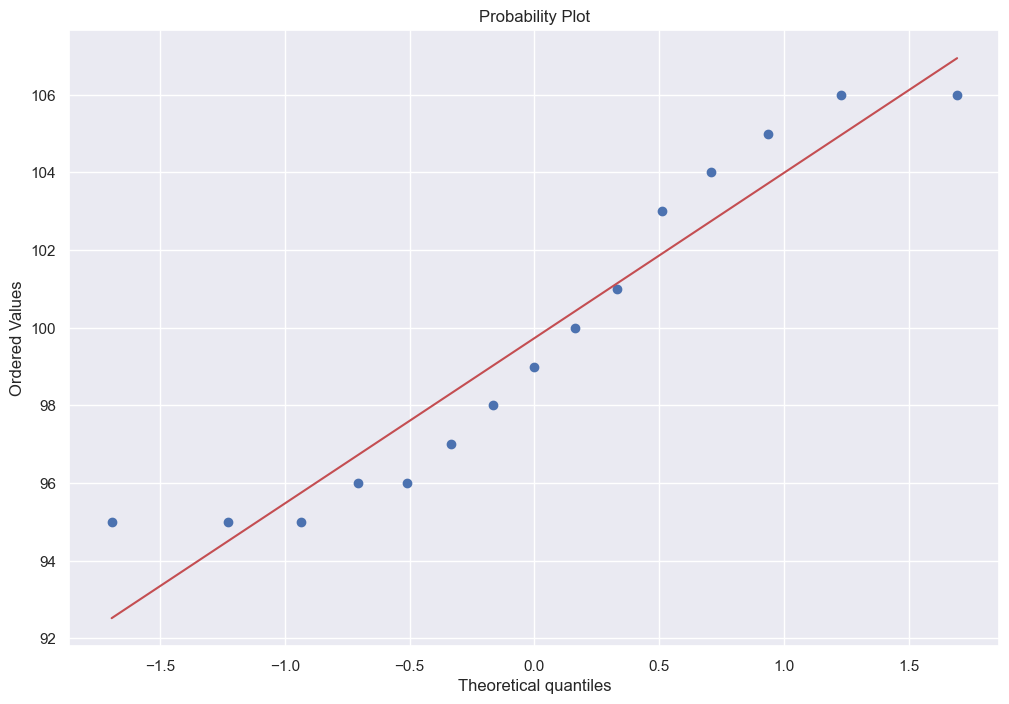

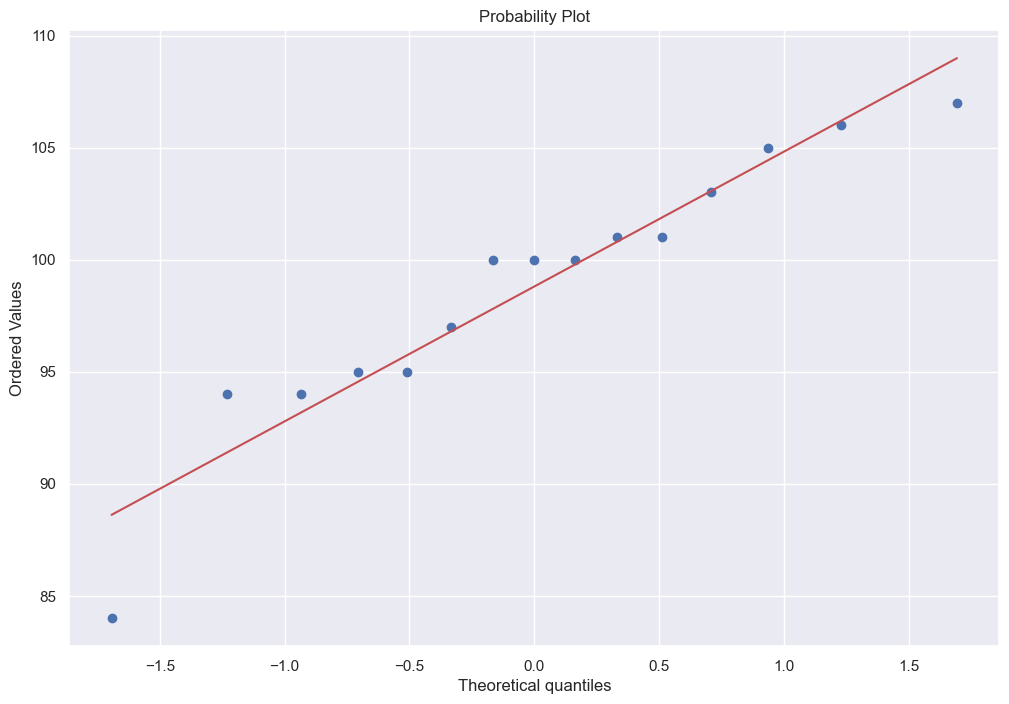

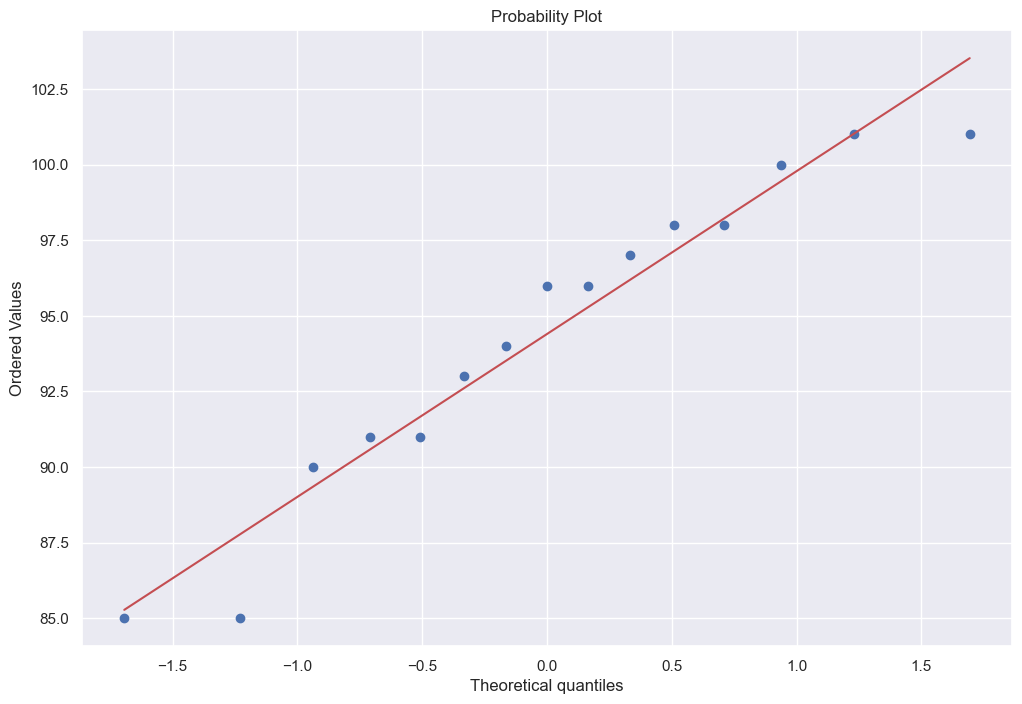

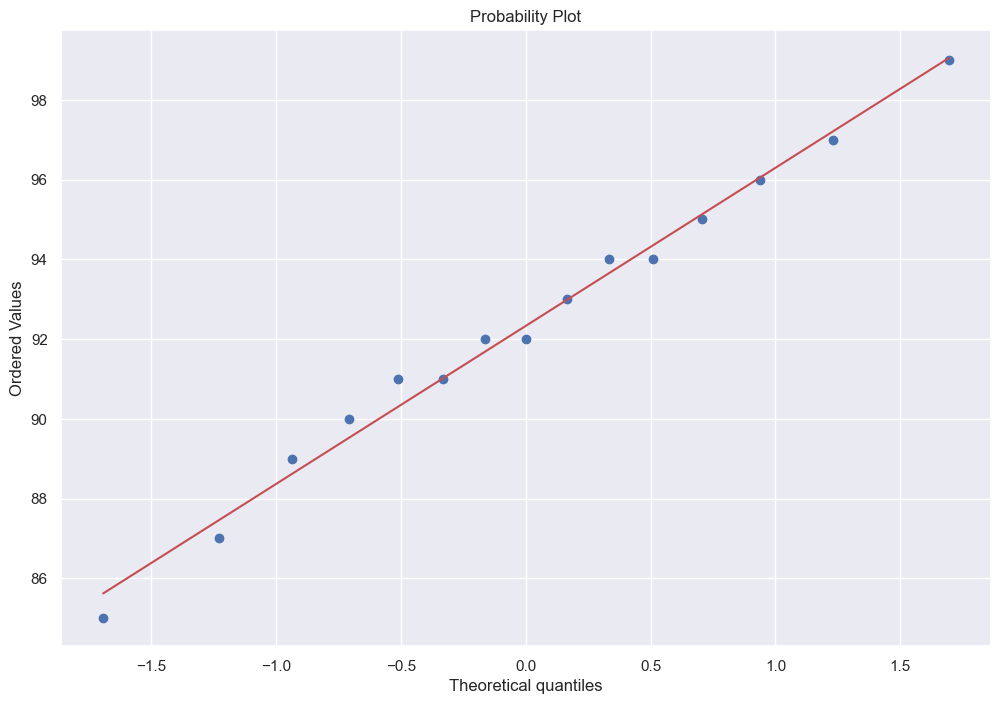

In [79]:
for gr in ['A', 'B', 'C', 'D']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    res = stats.probplot(df[df.Therapy==gr].expr, plot=ax)

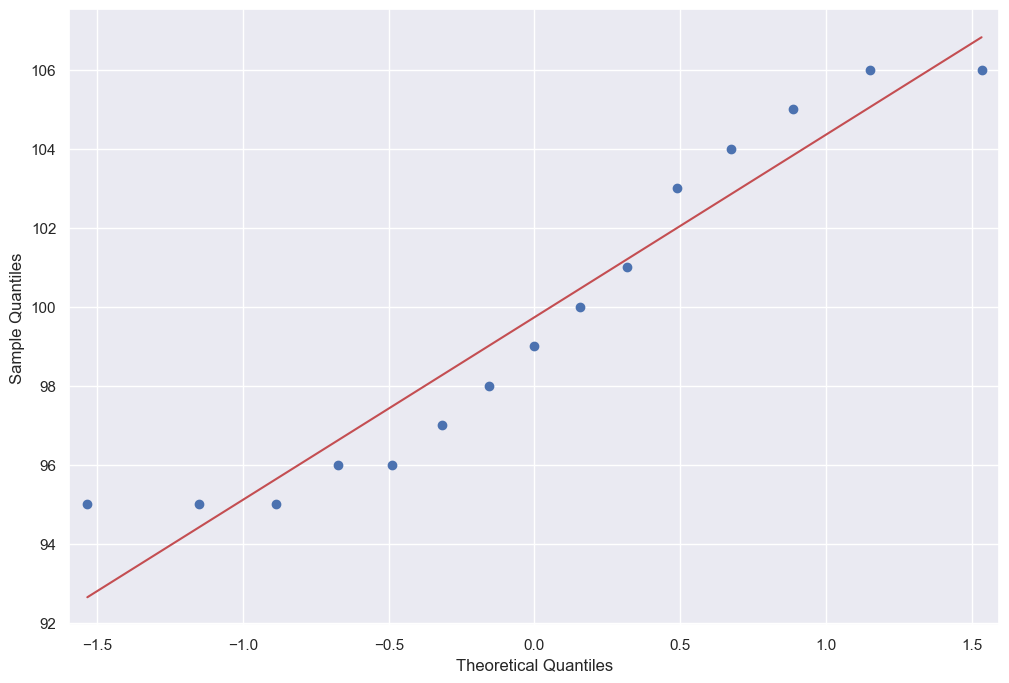

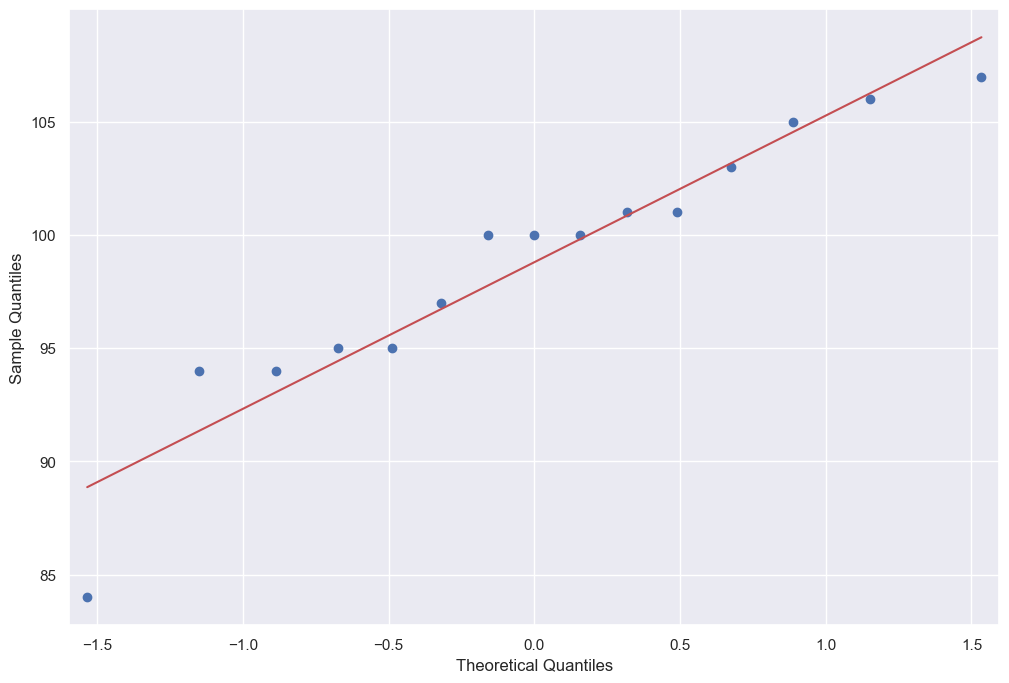

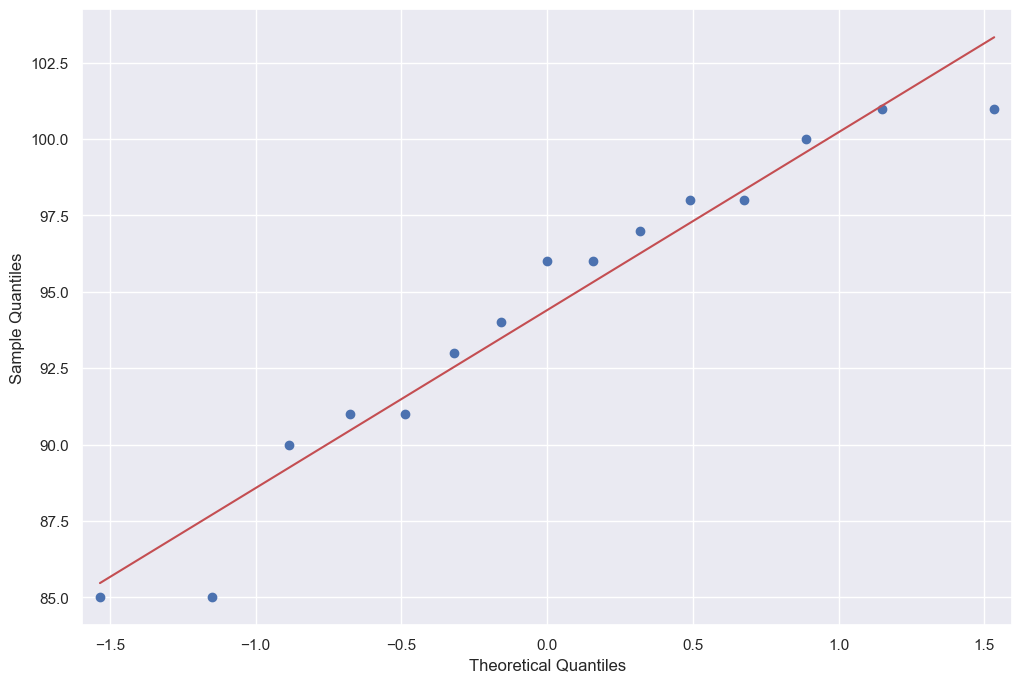

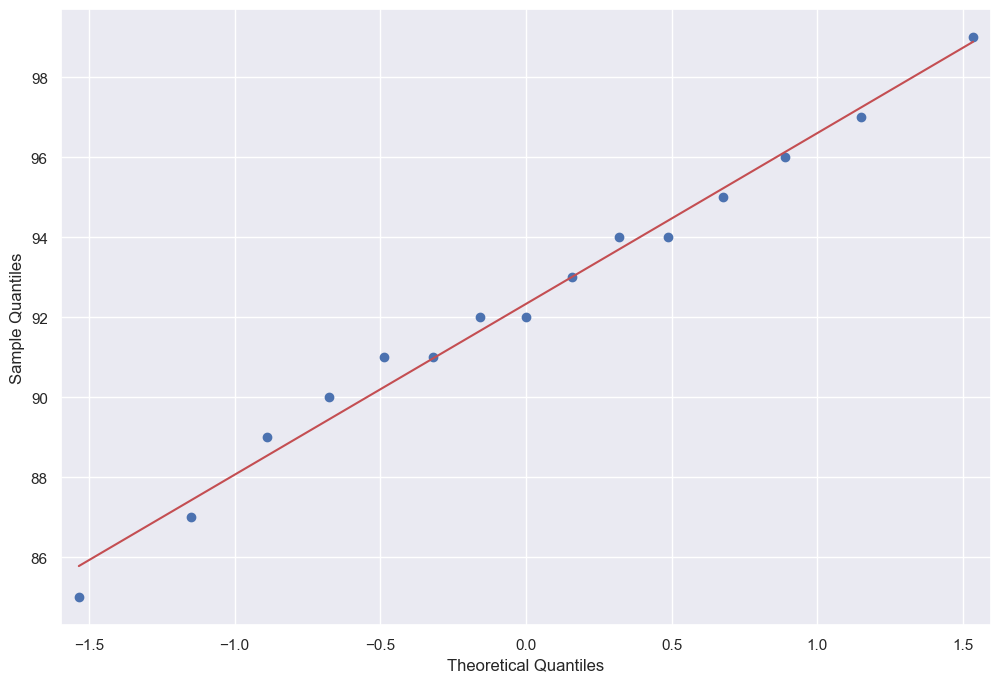

In [80]:
#другой функцией
for i, gr in zip([*range(4)], ['A', 'B', 'C', 'D']):
    fig = sm.qqplot(df[df.Therapy==gr].expr, line='r')
    #fig = sm.qqplot(dfshap[i], line='45')
    plt.show()

* **Распределение в группе B не является нормальным**
* **Распределение в группе A не является нормальным**
* **Распределение в группе С не является нормальным**
* **Распределение в группе D не является нормальным**
* Все утверждения не верны

данные со степика отличаются наличием группы D

# Задание 4
Самое время провести тест! 

In [81]:
# pg.anova(data=df, dv='expr', between='Therapy')

In [82]:
# stats.f_oneway(df[df.Therapy=='A'].expr,
#                df[df.Therapy=='B'].expr,
#                df[df.Therapy=='C'].expr,
#                df[df.Therapy=='D'].expr)
stats.f_oneway(df[df.Therapy=='A'].expr,
               df[df.Therapy=='B'].expr,
               df[df.Therapy=='C'].expr,
               df[df.Therapy=='D'].expr)

F_onewayResult(statistic=8.03730248114399, pvalue=0.0001524972289522953)

In [83]:

#откл H0
#хотя бы одна пара ср отличается
#тест исследует влияние терапии на эскр гена 
#- как минимум какая-то из терапий отличается от ост
#cходится с https://stepik.org/lesson/8083/step/11?unit=1362

Для сравнения средних я использую `ОДНОФАКТОРНЫЙ ДИСПЕРСИОННЫЙ АНАЛИЗ`. Значение статистики равно (окр. до целого) `8`, а р-уровень значимости составил `0.00015`.

# Задание 5
Теперь используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 

Дополнительно: попробуйте другие варианты поправок на множественные сравнения через pingouin. Дают ли они те же выводы, что и Тьюки?

In [84]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
MultiComparison)
print(pairwise_tukeyhsd(df.expr, df.Therapy))
#или
MultiComp = MultiComparison(df.expr, df.Therapy)
print(MultiComp.tukeyhsd().summary())
#rej H0 = разл есть =>
#AB BC CD не отл
#AC AD BD отл

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333 0.9514  -5.5959  3.7292  False
     A      C  -5.3333 0.0189  -9.9959 -0.6708   True
     A      D     -7.4 0.0005 -12.0626 -2.7374   True
     B      C     -4.4  0.071  -9.0626  0.2626  False
     B      D  -6.4667 0.0029 -11.1292 -1.8041   True
     C      D  -2.0667 0.6458  -6.7292  2.5959  False
-----------------------------------------------------
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B  -0.9333 0.9514  -5.5959  3.7292  False
     A      C  -5.3333 0.0189  -9.9959 -0.6708   True
     A      D     -7.4 0.0005 -12.0626 -2.7374   True
     B      C     -4.4  0.071  -9.0626  0.2626  False
     B      D  -6.4667 0.0029 -11.1292 -1.8041   True
     C      D  -2.0667 0.645

<br>**A-B B-C C-D _(каждая пара)не отличаются между собой_**
<br>**A-C A-D B-D _отличаются между собой_**


# Задание 6
какие терапии будем использовать? 

<br>- нужно проверить средний уровень экспрессии кажд группы
<br>ген более деффективный когда меньше mean expr 

In [85]:
df.groupby('Therapy').expr.mean()

Therapy
A    99.733333
B    98.800000
C    94.400000
D    92.333333
Name: expr, dtype: float64

**терапия D самая успешная**

# Задание 7
Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Какой метод скорее всего пригодится в данном случае?

* хи-квадрат
* t-test
* **многофакторный дисперсионный анализ**
* однофакторный дисперсионный анализ

# Задание 8
Посмотрим на данные. Визуализируйте распределение уровня экспрессии для контрольной и тестовой групп. 

In [86]:
df2.dose.unique()

array(['D1', 'D2'], dtype=object)

<Axes: >

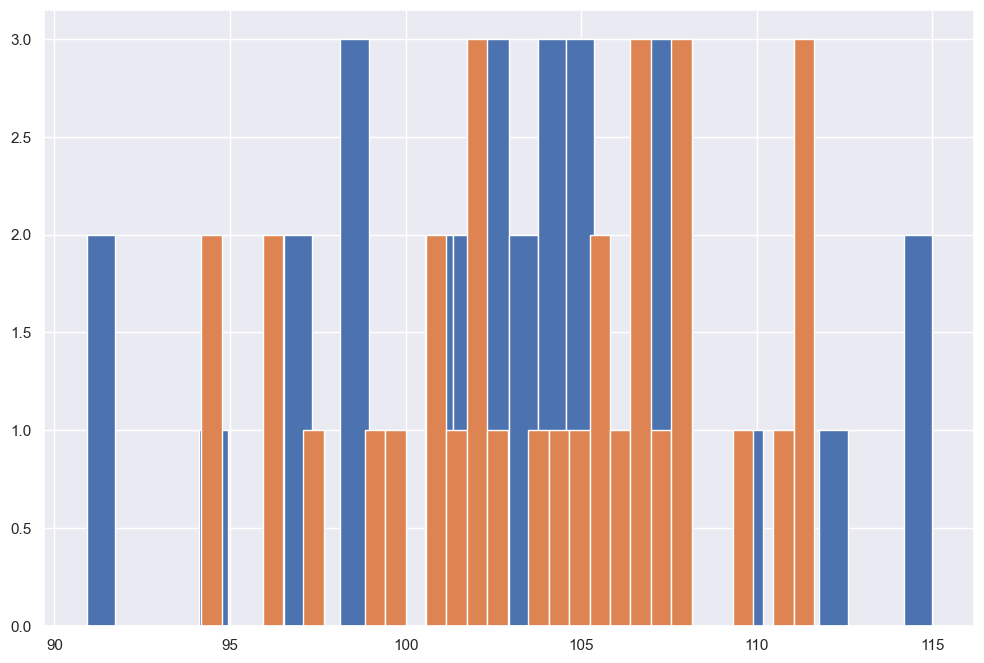

In [87]:
df2.query('dose=="D1"').expr.hist(bins=30)
df2.query('dose=="D2"').expr.hist(bins=30)

In [88]:
stats.levene(df2.query("dose == 'D1'").expr, 
                   df2.query("dose == 'D2'").expr)
#дисперсии равны
#gameshowell вместо tukey не нужен

LeveneResult(statistic=0.04971157202561868, pvalue=0.8242988587700746)

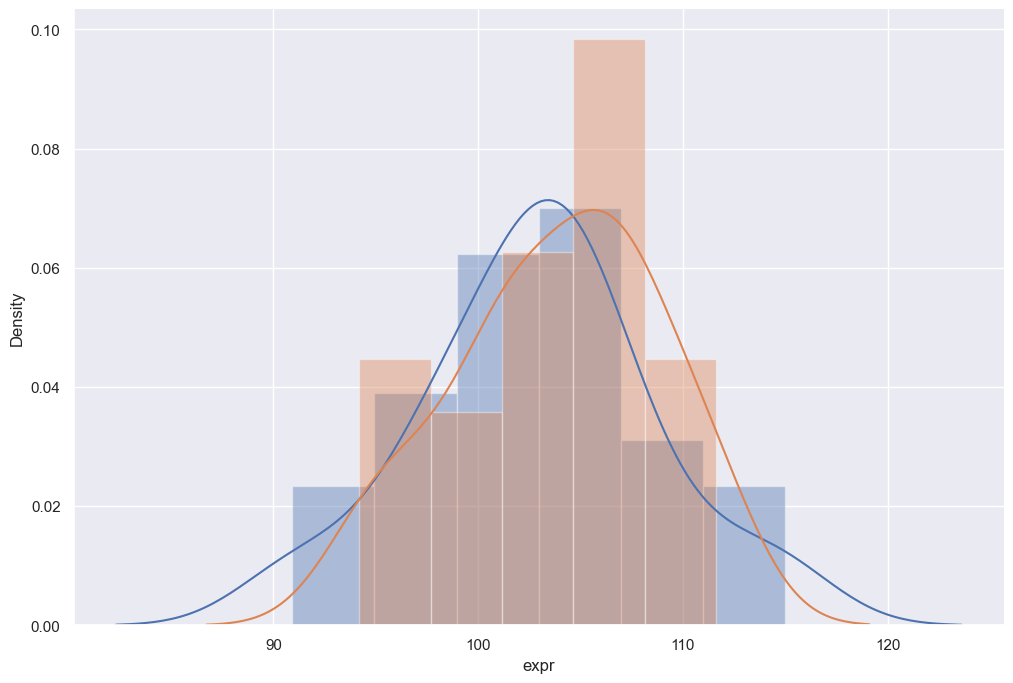

In [89]:
#тот же график, но эстетичнее
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.distplot(df2.query("dose == 'D1'").expr)
sns.distplot(df2.query("dose == 'D2'").expr)
sns.despine()

# Задание 9
Посчитайте среднее, медиану и стандартное отклонение expr в разбивке по группе и по возрасту пациента. 

In [90]:
for i in ['D1', 'D2']:
    for j in [1,2]:
        print(i,j,'\n','std', df2.query('dose==@i and age==@j').expr.std().round(2),
             'mean', df2.query('dose==@i and age==@j').expr.mean().round(2),
             'median', df2.query('dose==@i and age==@j').expr.median().round(2))

D1 1 
 std 5.86 mean 104.76 median 104.78
D1 2 
 std 5.12 mean 101.0 median 100.91
D2 1 
 std 4.37 mean 105.55 median 106.55
D2 2 
 std 5.14 mean 102.27 median 101.88


# Задание 10

Почти у цели – осталось выбрать формулу для модели. 

Если вы прибегнете к statsmodels, то какую формулу используете?

* **formula = 'expr ~ dose + age + dose:age'**

# Задание 11
Проведите тест (через `anova_lm` либо `pg.anova`), а затем используйте критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в `MultiComparison` либо `pairwise_tukey`:


| group | segment | combination |
|-------|---------|-------------|
| test  | high    | test / high |
| test  | high    | test / high |

Между какими группами были обнаружены статистически значимые различия? 

Note:  При интерпретации обратите внимание на то, какая из групп с какой сравнивается и как считается meandiff.

In [92]:
pingouin.anova(data=df2, dv='expr', between=['age','dose'])
#p-unc = p-val
#различ дает ток возраст

,Source,SS,DF,MS,F,p-unc,np2
0,age,197.452754,1,197.452754,7.449841,0.008313,0.110450
1,dose,16.912241,1,16.912241,0.638094,0.427552,0.010523
2,age * dose,0.927077,1,0.927077,0.034978,0.852272,0.000583
3,Residual,1590.257424,60,26.504290,NaN,NaN,NaN


In [95]:
df2.combination = df2.dose + '/' + df2.age.astype(str)
print(pairwise_tukeyhsd(df2.expr, df2.combination))
#разл нет

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  D1/1   D1/2  -3.7537 0.1774 -8.5635 1.0562  False
  D1/1   D2/1   0.7874 0.9726 -4.0225 5.5973  False
  D1/1   D2/2  -2.4848 0.5259 -7.2947  2.325  False
  D1/2   D2/1   4.5411  0.071 -0.2688 9.3509  False
  D1/2   D2/2   1.2688 0.8978  -3.541 6.0787  False
  D2/1   D2/2  -3.2722 0.2845 -8.0821 1.5376  False
---------------------------------------------------


In [108]:
df2.query('dose=="D1" and age==1').expr.mean()-df2.query('dose=="D2" and age==1').expr.mean()

-0.7874002279420864

In [96]:
#meandiff = D1/1 - D2/1 < 0 => D2/1 > D1/1 = увеличение

# Задание 12
Визуализируйте результаты теста и заполните пропуски:

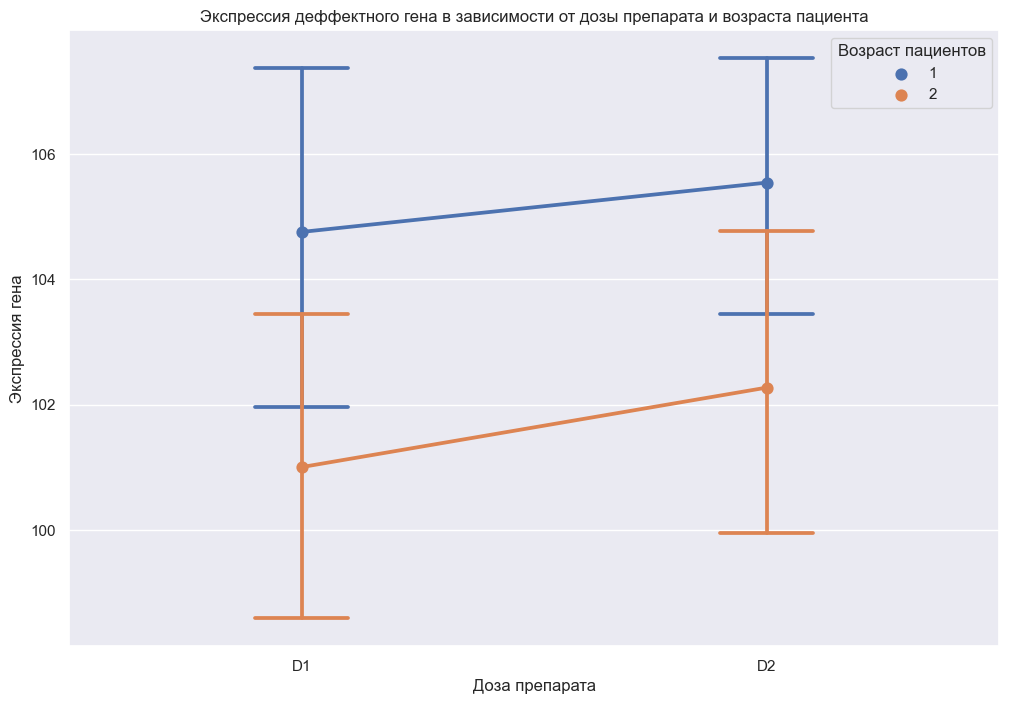

In [97]:
sns.pointplot(x = 'dose', y = 'expr', hue = 'age', data = df2, capsize = .2)
plt.title('Экспрессия деффектного гена в зависимости от дозы препарата и возраста пациента')
plt.xlabel('Доза препарата')
plt.ylabel('Экспрессия гена')
plt.legend(title = 'Возраст пациентов')

Фактор age оказался `ЗНАЧИМЫМ`, фактор dose – `неЗНАЧИМЫМ`, их взаимодействие – `неЗНАЧИМО`. Поэтому решение: `неиспользуем НОВУЮ дозу`